In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai
from fastai.text import *
from fastai.vision import *
from fastai.utils.mem import *
from statsmodels.graphics.tsaplots import plot_acf
import sklearn.metrics as metrics
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.ar_model import AutoReg
from matplotlib.widgets import Slider, Button, RadioButtons
from fastai.callbacks import *
from fastai.basic_train import Learner, LearnerCallback

In [3]:
path = Path("data/LFP_Prediction")

In [4]:
df = pd.read_csv(path/"model_fr_lfp_new.csv")

In [5]:
df["avgPNA"] = np.array([df.PNA1, df.PNA2, df.PNA3, df.PNA4, df.PNA5]).mean(0)
df["avgPNC"] = np.array([df.PNC1, df.PNC2, df.PNC3, df.PNC4, df.PNC5]).mean(0)
df["avgITN"] = np.array([df.ITN1, df.ITN2, df.ITN3, df.ITN4, df.ITN5]).mean(0)

In [6]:
raw = df["rawLFP"]

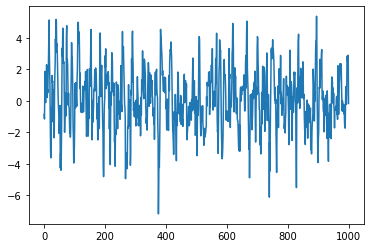

In [7]:
plt.plot(raw[:1000])

In [8]:
len(df)

199500

In [9]:
df.head()

,PNA1,PNA2,PNA3,PNA4,PNA5,PNC1,PNC2,PNC3,PNC4,PNC5,...,ITN2,ITN3,ITN4,ITN5,rawLFP,filtLFP,hilbLFP,avgPNA,avgPNC,avgITN
0,0.0,0.00000,0.2739,0.79453,0.45424,0.0,0.0000,0.00000,0.79777,0.59773,...,16.129,18.165,19.241,22.929,-0.858470,0.55633,0.62672,0.304534,0.279100,27.2928
1,0.0,1.45240,0.5478,0.79453,0.68135,0.0,0.0000,0.00000,0.39888,0.59773,...,18.433,15.441,16.121,14.053,-1.146800,0.68830,0.73526,0.695216,0.199322,12.8096
2,0.0,0.72622,0.2739,0.00000,0.68135,0.0,0.0000,0.71023,1.19660,0.00000,...,20.737,21.798,17.681,13.314,0.483210,0.69304,0.85662,0.336294,0.381366,14.7060
3,0.0,0.72622,0.2739,0.79453,0.22712,0.0,1.8416,0.71023,0.39888,0.59773,...,13.825,13.624,24.441,13.314,1.875100,0.55921,0.90646,0.404354,0.709688,13.0408
4,0.0,1.45240,0.5478,0.15891,1.36270,0.0,0.0000,2.13070,0.79777,1.19550,...,16.129,23.615,14.041,16.272,0.093743,0.30411,0.94929,0.704362,0.824794,14.0114


In [10]:
df.describe()

,PNA1,PNA2,PNA3,PNA4,PNA5,PNC1,PNC2,PNC3,PNC4,PNC5,...,ITN2,ITN3,ITN4,ITN5,rawLFP,filtLFP,hilbLFP,avgPNA,avgPNC,avgITN
count,199500.000000,199500.000000,199500.000000,199500.000000,199500.000000,199500.000000,199500.000000,199500.000000,199500.000000,199500.000000,...,199500.000000,199500.000000,199500.000000,199500.000000,1.995000e+05,199500.000000,199500.000000,199500.000000,199500.000000,199500.000000
mean,0.398085,0.405951,0.395607,0.465058,0.565680,0.579476,0.610166,0.585745,0.731711,0.941987,...,16.817417,18.395894,18.345235,15.516352,-7.889371e-08,0.000015,1.256058,0.446076,0.689817,17.553646
std,1.392017,0.547565,0.331992,0.272653,0.358851,2.713647,1.064858,0.645774,0.540447,0.749967,...,7.545045,4.896905,3.698422,3.768385,1.921718e+00,1.000000,0.649854,0.320551,0.625645,5.144952
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.816500,5.200200,2.218900,-8.835700e+00,-4.675900,0.002924,0.000000,0.000000,5.466940
25%,0.000000,0.000000,0.273900,0.317810,0.227120,0.000000,0.000000,0.000000,0.398880,0.597730,...,11.521000,14.532000,15.601000,12.574000,-1.298500e+00,-0.678928,0.764317,0.263396,0.358640,13.738150
50%,0.000000,0.000000,0.273900,0.476720,0.454240,0.000000,0.000000,0.710230,0.797770,0.597730,...,16.129000,18.165000,18.201000,15.533000,-4.548200e-02,-0.000298,1.183300,0.367686,0.557956,16.762000
75%,0.000000,0.726220,0.547800,0.635630,0.681350,0.000000,1.841600,0.710230,1.196600,1.195500,...,20.737000,21.798000,20.801000,17.751000,1.253725e+00,0.677485,1.669700,0.500440,0.802294,20.475250
max,19.417000,4.357300,2.465100,2.224700,2.952500,37.975000,9.208100,4.971600,3.988800,5.977300,...,62.212000,44.505000,40.042000,38.462000,9.290300e+00,4.493200,4.705700,4.341932,8.583786,58.795800


# Graphing of neuronal action

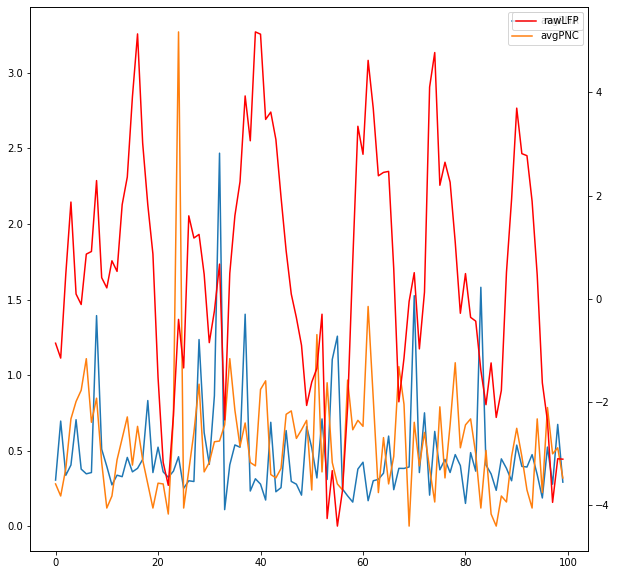

In [11]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
plt.plot('avgPNA', data = df.iloc[:100])
plt.plot('avgPNC', data = df.iloc[:100])
plt.legend()

# Get second axis
ax2 = ax.twinx()
plt.plot("rawLFP", 'r', data = df.iloc[:100])
plt.legend()

plt.show()

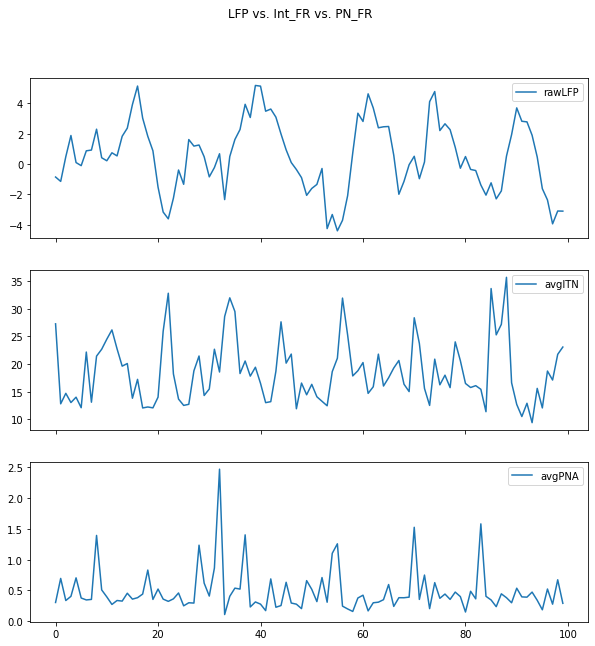

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)
fig.set_size_inches(10, 10)
fig.suptitle('LFP vs. Int_FR vs. PN_FR')

ax1.plot("rawLFP", data = df.iloc[:100], label = "rawLFP")
ax2.plot('avgITN', data = df.iloc[:100], label = "avgITN")
ax3.plot('avgPNA', data = df.iloc[:100], label = 'avgPNA')

ax1.legend()
ax2.legend()
ax3.legend()

plt.show()

In [28]:
def ev_model(x, y, metric, model, pred_func):
    preds, _ = pred_func(x, model, 30)
    test_score = metric(y, preds)
    print('Test RMSE: %.5f' % test_score)
    
    for i in range(len(preds)):
        print("Pred:", preds[i], "   ", "Actual:", y[i])
        
    x_xs = np.arange(0, 80)
    y_xs = np.arange(50, 80)
    # plot predictions vs expected
    plt.plot(x_xs, np.concatenate((x[-50:], y)), label = "actual")
    plt.plot(y_xs, preds, color='red', label = "prediction")
    plt.legend()
    plt.show()

In [14]:
def RMSE(y, y_hat):
    return math.sqrt(metrics.mean_squared_error(y, y_hat))

In [20]:
def get_score(x, model, pred_func, metric):
    total = 0
    count = 0
    for i in range(129, len(x) - 30):
        count += 1
        X = x[i - 129 : i]
        y  = x[i : i + 30]
        preds, _ = pred_func(X, model, 30)
        total += metric(y, preds)
        
    return total / count

## Baseline persistence model

In [21]:
X = raw.values
train, test = X[1:len(X)-30], X[len(X)-30:]
t = X[0 : -100000]
v = X[-100000:]

In [22]:
def model_persistence(x):
    return x[-1]

In [23]:
def persistence_preds(all_x, x, model, num_preds):
    preds = []
    for i in range(num_preds):
        preds.append(x[-1])
        
    return preds, x

In [24]:
get_score(v, model_persistence, partial(persistence_preds, X), RMSE)

2.514058610119582

Test RMSE: 3.04832
Pred: 1.5708     Actual: 0.573
Pred: 1.5708     Actual: -2.1419
Pred: 1.5708     Actual: -2.7943
Pred: 1.5708     Actual: -2.424
Pred: 1.5708     Actual: -0.6610199999999999
Pred: 1.5708     Actual: -0.48052
Pred: 1.5708     Actual: -0.48815
Pred: 1.5708     Actual: -1.6646
Pred: 1.5708     Actual: -2.3282
Pred: 1.5708     Actual: -1.7296
Pred: 1.5708     Actual: 0.046117
Pred: 1.5708     Actual: 0.95225
Pred: 1.5708     Actual: 0.30188000000000004
Pred: 1.5708     Actual: 1.682
Pred: 1.5708     Actual: 1.0282
Pred: 1.5708     Actual: 0.8907
Pred: 1.5708     Actual: -2.6161
Pred: 1.5708     Actual: -1.8011
Pred: 1.5708     Actual: -2.8098
Pred: 1.5708     Actual: -2.8695
Pred: 1.5708     Actual: -4.2265
Pred: 1.5708     Actual: -5.379
Pred: 1.5708     Actual: -1.3203
Pred: 1.5708     Actual: 2.1002
Pred: 1.5708     Actual: 3.2214
Pred: 1.5708     Actual: 3.9185
Pred: 1.5708     Actual: 3.2955
Pred: 1.5708     Actual: 3.2578
Pred: 1.5708     Actual: 2.6579
Pred: 1.570

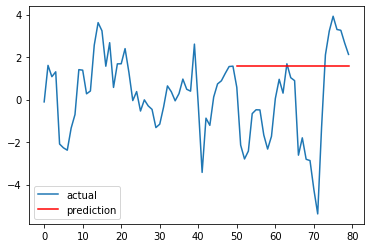

In [29]:
ev_model(train, test, RMSE, model_persistence, partial(persistence_preds, X[1:]))

# Autoregression

Correlation between y(t) and y(t + 1)

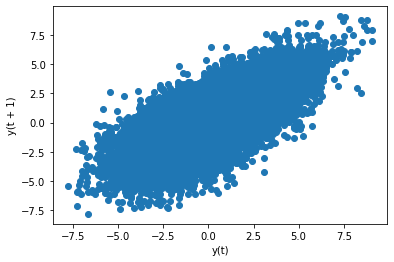

In [30]:
pd.plotting.lag_plot(raw[:50000])
plt.show()

Correlation between y(t) and y(t + x) for x between 0 and 10

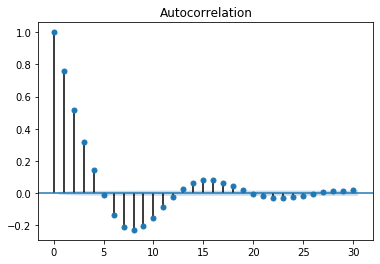

In [31]:
plot_acf(raw[:50000], lags = 30)
plt.show()

In [34]:
def AR_pred(x, model, num_preds, full_forecast = True):
    window = model.k_ar
    coef = model.params
    history = list(x[-window:])
    
    preds = []
    for i in range(num_preds):
        y_hat = coef[0]
        for j in range(len(history)):
            y_hat += coef[1 + j] * history[window - j - 1]
        preds.append(y_hat)
        if full_forecast:
            history.append(y_hat)
        else:
            history.append(test[i])
        history = history[1:]
        x = np.append(x, y_hat)
    
    return preds, x

In [35]:
# split dataset
X = raw.values
train, test = X[1:len(X)-30], X[len(X)-30:]
valid = train[-100000:]
train = train[:-100000]

In [36]:
# train autoregression
model = AR(train)
model_fit = model.fit()

D:\adina\Anaconda3\envs\fastai_v1\lib\site-packages\statsmodels\tsa\ar_model.py:691: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWar

In [37]:
get_score(valid, model_fit, AR_pred, RMSE)

1.8245652684160751

Full 10 ms prediction

Test RMSE: 2.14253
Pred: -1.2121909377729971     Actual: -1.1532
Pred: -0.4742872705190894     Actual: -0.40509
Pred: -0.03088607798837159     Actual: 1.4266
Pred: 0.12602654371215907     Actual: 3.699
Pred: 0.21077589210640235     Actual: 4.1408
Pred: 0.23258471355586957     Actual: 3.4489
Pred: 0.2876147250085489     Actual: 2.855
Pred: 0.24106775881171721     Actual: 1.7344
Pred: 0.21784215242369637     Actual: -0.17581
Pred: 0.1154567831730198     Actual: -2.5479
Pred: 0.01585527590933015     Actual: -5.0118
Pred: -0.03658105253165651     Actual: -2.2252
Pred: -0.07287912953499537     Actual: -3.2789
Pred: -0.10065632440804213     Actual: -3.9923
Pred: -0.09707875619674587     Actual: -2.5725
Pred: -0.043934305351661235     Actual: -0.5894699999999999
Pred: 0.0236371810943595     Actual: -0.95642
Pred: 0.061061862363856564     Actual: 0.98713
Pred: 0.07111590586378984     Actual: 1.1799
Pred: 0.07084927212820434     Actual: 0.8086300000000001
Pred: 0.08999033134686164     Actual: 1

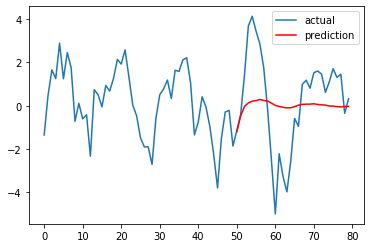

In [38]:
ev_model(valid[:1219], valid[1219: 1249], RMSE, model_fit, AR_pred)

# Deep Learning

In [11]:
mse = nn.MSELoss()

#mean absolute error
L1 = nn.L1Loss()

In [12]:
def RMSELoss(yhat,y):
    return torch.sqrt(mse(yhat, y))

In [13]:
def MAELoss(yhat, y):
    return L1(yhat, y)

Two main classes needed to make a fastai dataset

In [14]:
class TargetTimePoints(ItemList):
    def reconstruct(self, t:Tensor): 
        return t

In [15]:
class TimePoints(ItemBase):
    def __init__(self, timePoints):
        self.obj = (timePoints)
        #self.data = torch.Tensor(list(timePoints)).reshape(1, len(timePoints))
        self.data = torch.Tensor(list(timePoints))[None]
    def to_one(self): return self.data
    
    def apply_tfms(self, tfms, **kwargs):
        return
    
    def __repr__(self):
        return "A time points"

In [16]:
class TimePointsList(ItemList):
    _label_cls = TargetTimePoints
    def __init__(self, items, num_back, num_preds, **kwargs):
        self.its = items
        super().__init__(items[:-(num_back + num_preds)], **kwargs)
        self.num_preds = num_preds
        self.num_back = num_back
        self.copy_new.append("num_back")
        self.copy_new.append("num_preds")
        
    def get(self, i):
        return TimePoints(self.its[i : self.num_back + i])
    
    def reconstruct(self, t:Tensor):
        return TimePoints(list(t[0]))
    
    def __len__(self):
        return len(self.its) - self.num_back - self.num_preds
    
    def label_from_func(self, func:Callable, label_cls:Callable=None, **kwargs)->'LabelList':
        "Apply `func` to every input to get its label."
        return self._label_from_list([self.label_func(o) for o in range(0, len(self))], label_cls=label_cls, **kwargs)
    
    def label_func(self, i):
        return torch.Tensor(list(self.its[i + self.num_back: i + self.num_back + self.num_preds]))[None]

Used to evaluate the models

## Univariate LSTM

In [17]:
len(raw)

199500

In [18]:
num_back = 100
num_preds = 30

data = (TimePointsList(list(raw), num_back, num_preds)
                .split_by_idx(range(100000))#makes the first 500000 ms a validation set
                .label_from_func(lambda x: x)
                .databunch(bs = 128, num_workers = 0))

In [19]:
data

DataBunch;

Train: LabelList (99240 items)
x: TimePointsList
A time points,A time points,A time points,A time points,A time points
y: TargetTimePoints
tensor([[-1.0886, -0.8908, -1.1048, -2.3449, -3.2749, -3.5930, -2.1525, -2.0038,
         -2.8043, -2.3670, -3.1083, -2.7444, -3.4937, -3.1875, -1.0262, -0.3800,
          0.4752,  0.0055, -0.1550, -0.8116, -1.0607, -0.7247,  1.7487,  1.4046,
          1.3173,  2.0793,  0.5842,  1.4477,  2.1981,  2.6715]]),tensor([[-0.8908, -1.1048, -2.3449, -3.2749, -3.5930, -2.1525, -2.0038, -2.8043,
         -2.3670, -3.1083, -2.7444, -3.4937, -3.1875, -1.0262, -0.3800,  0.4752,
          0.0055, -0.1550, -0.8116, -1.0607, -0.7247,  1.7487,  1.4046,  1.3173,
          2.0793,  0.5842,  1.4477,  2.1981,  2.6715,  3.3124]]),tensor([[-1.1048, -2.3449, -3.2749, -3.5930, -2.1525, -2.0038, -2.8043, -2.3670,
         -3.1083, -2.7444, -3.4937, -3.1875, -1.0262, -0.3800,  0.4752,  0.0055,
         -0.1550, -0.8116, -1.0607, -0.7247,  1.7487,  1.4046,  1.3173,

In [20]:
class Simple_LSTM(nn.Module):
    def __init__(self, in_size, out_size):
        super().__init__()
        self.rnn = nn.LSTM(in_size, in_size, 1, batch_first = True)
        self.drop = nn.Dropout(0.25)
        self.h_o = nn.Linear(in_size,out_size)
        
    def forward(self, x):
        res,h = self.rnn(x)
        res = self.drop(res)
        return self.h_o(res)

In [21]:
learn = Learner(data, Simple_LSTM(num_back, num_preds), loss_func = RMSELoss, metrics = MAELoss, wd = 1e-4)

In [52]:
callbacks = [EarlyStoppingCallback(learn, patience = 5),
                    SaveModelCallback(learn, every='improvement', monitor='valid_loss')]

In [53]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-07
Min loss divided by 10: 8.32E-03


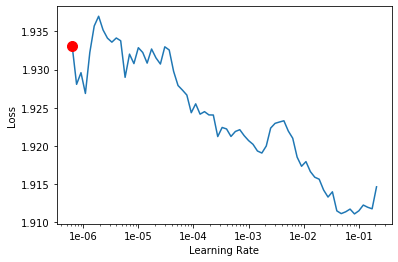

In [55]:
learn.recorder.plot(suggestion = True, skip_end = 20)

In [56]:
lr = 1e-3

In [57]:
learn.fit_one_cycle(20, lr, callbacks=callbacks)

epoch,train_loss,valid_loss,MAELoss,time
0,1.917783,1.892598,1.507978,00:22
1,1.888302,1.860303,1.478179,00:24
2,1.879110,1.853997,1.471518,00:26
3,1.876345,1.853675,1.471143,00:23
4,1.869666,1.854385,1.471804,00:21
5,1.865850,1.854652,1.472037,00:23
6,1.863383,1.856461,1.473619,00:22
7,1.867158,1.857527,1.474467,00:22
8,1.858011,1.858719,1.475509,00:23


Better model found at epoch 0 with valid_loss value: 1.8925981521606445.
Better model found at epoch 1 with valid_loss value: 1.8603034019470215.
Better model found at epoch 2 with valid_loss value: 1.8539971113204956.
Better model found at epoch 3 with valid_loss value: 1.8536747694015503.
Epoch 9: early stopping


In [59]:
#learn.save("current_uni-LSTM30-1")
learn.load("current_uni-LSTM30-1")

Learner(data=DataBunch;

Train: LabelList (99240 items)
x: TimePointsList
A time points,A time points,A time points,A time points,A time points
y: TargetTimePoints
tensor([[-1.0886, -0.8908, -1.1048, -2.3449, -3.2749, -3.5930, -2.1525, -2.0038,
         -2.8043, -2.3670, -3.1083, -2.7444, -3.4937, -3.1875, -1.0262, -0.3800,
          0.4752,  0.0055, -0.1550, -0.8116, -1.0607, -0.7247,  1.7487,  1.4046,
          1.3173,  2.0793,  0.5842,  1.4477,  2.1981,  2.6715]]),tensor([[-0.8908, -1.1048, -2.3449, -3.2749, -3.5930, -2.1525, -2.0038, -2.8043,
         -2.3670, -3.1083, -2.7444, -3.4937, -3.1875, -1.0262, -0.3800,  0.4752,
          0.0055, -0.1550, -0.8116, -1.0607, -0.7247,  1.7487,  1.4046,  1.3173,
          2.0793,  0.5842,  1.4477,  2.1981,  2.6715,  3.3124]]),tensor([[-1.1048, -2.3449, -3.2749, -3.5930, -2.1525, -2.0038, -2.8043, -2.3670,
         -3.1083, -2.7444, -3.4937, -3.1875, -1.0262, -0.3800,  0.4752,  0.0055,
         -0.1550, -0.8116, -1.0607, -0.7247,  1.7487,  1.4

In [60]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


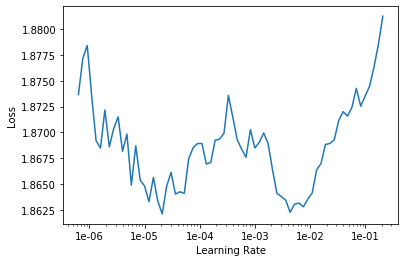

In [63]:
learn.recorder.plot(skip_end = 20)

In [64]:
lr = 5e-4

In [65]:
learn.fit_one_cycle(20, lr, callbacks=callbacks)

epoch,train_loss,valid_loss,MAELoss,time
0,1.863911,1.853446,1.470889,00:24
1,1.870765,1.853321,1.470776,00:23
2,1.868216,1.853518,1.470943,00:23
3,1.866099,1.853973,1.471311,00:23
4,1.868540,1.854582,1.471796,00:22
5,1.868461,1.854974,1.472345,00:23
6,1.865371,1.855662,1.472978,00:24


Better model found at epoch 0 with valid_loss value: 1.8534457683563232.
Better model found at epoch 1 with valid_loss value: 1.8533210754394531.
Epoch 7: early stopping


In [22]:
#learn.save("current_uni-LSTM30-2")
learn.load("current_uni-LSTM30-2")

Learner(data=DataBunch;

Train: LabelList (99240 items)
x: TimePointsList
A time points,A time points,A time points,A time points,A time points
y: TargetTimePoints
tensor([[-1.0886, -0.8908, -1.1048, -2.3449, -3.2749, -3.5930, -2.1525, -2.0038,
         -2.8043, -2.3670, -3.1083, -2.7444, -3.4937, -3.1875, -1.0262, -0.3800,
          0.4752,  0.0055, -0.1550, -0.8116, -1.0607, -0.7247,  1.7487,  1.4046,
          1.3173,  2.0793,  0.5842,  1.4477,  2.1981,  2.6715]]),tensor([[-0.8908, -1.1048, -2.3449, -3.2749, -3.5930, -2.1525, -2.0038, -2.8043,
         -2.3670, -3.1083, -2.7444, -3.4937, -3.1875, -1.0262, -0.3800,  0.4752,
          0.0055, -0.1550, -0.8116, -1.0607, -0.7247,  1.7487,  1.4046,  1.3173,
          2.0793,  0.5842,  1.4477,  2.1981,  2.6715,  3.3124]]),tensor([[-1.1048, -2.3449, -3.2749, -3.5930, -2.1525, -2.0038, -2.8043, -2.3670,
         -3.1083, -2.7444, -3.4937, -3.1875, -1.0262, -0.3800,  0.4752,  0.0055,
         -0.1550, -0.8116, -1.0607, -0.7247,  1.7487,  1.4

In [24]:
learn.loss_func = nn.MSELoss()#This is just to make it run.
uni_interp = Interpretation.from_learner(learn)

In [25]:
#MAE at each timestep from 1 to 10.
uni_mae_scores = []
for i in range(num_preds):
    uni_mae_scores.append(np.array(np.abs(uni_interp.y_true[:, 0, i] - uni_interp.preds[:, 0, i])))
    
uni_mae_scores = np.array(uni_mae_scores)

In [28]:
for i in range(num_preds):
    print(uni_mae_scores[i].mean())

0.9570158
1.2383423
1.3665416
1.4264078
1.4545176
1.466225
1.468679
1.4718081
1.4801544
1.492424
1.5020715
1.5082245
1.5107454
1.5111039
1.5113714
1.512768
1.5140527
1.5153915
1.516622
1.5176239
1.5177757
1.5182582
1.5180588
1.5176425
1.5181425
1.5181127
1.5185744
1.5184969
1.5180414
1.5181178


In [26]:
uni_rmse_scores = []
for i in range(num_preds):
    uni_rmse_scores.append(RMSELoss(uni_interp.preds[:, 0, i], uni_interp.y_true[:, 0, i]))

In [27]:
print(uni_rmse_scores)

[tensor(1.2341), tensor(1.5758), tensor(1.7307), tensor(1.8028), tensor(1.8383), tensor(1.8524), tensor(1.8552), tensor(1.8601), tensor(1.8708), tensor(1.8853), tensor(1.8981), tensor(1.9052), tensor(1.9085), tensor(1.9087), tensor(1.9089), tensor(1.9101), tensor(1.9120), tensor(1.9139), tensor(1.9152), tensor(1.9165), tensor(1.9166), tensor(1.9169), tensor(1.9168), tensor(1.9168), tensor(1.9170), tensor(1.9170), tensor(1.9172), tensor(1.9171), tensor(1.9167), tensor(1.9168)]


In [29]:
total = 0
for i in range(len(uni_interp.y_true)):
    total += RMSELoss(uni_interp.preds[i, 0, :],  uni_interp.y_true[i, 0, :])
    
uni_avg_rmse = total / len(uni_interp.y_true)

In [30]:
uni_avg_rmse

tensor(1.8139)

## Multivariate

In [31]:
combine = np.stack((df.rawLFP, df.avgITN, df.avgPNA, df.avgPNC), axis = -1)

In [32]:
combine.shape

(199500, 4)

In [33]:
class TargetTimePoints(ItemList):
    def reconstruct(self, t:Tensor): 
        return t

In [34]:
class TimePointsPlus(ItemBase):
    def __init__(self, timePoints, num_features, seq_len, reconstruct = False):
        self.obj = (timePoints)
        self.data = torch.Tensor(timePoints)
        #print(self.data.shape)
        if not reconstruct:
            #self.data = self.data.reshape((num_features, seq_len))
            self.data = torch.transpose(self.data, 0, 1)
        
    def to_one(self): return self.data
    
    def apply_tfms(self, tfms, **kwargs):
        return
    
    def __repr__(self):
        return "A time points plus"

In [35]:
class TimePointsPlusList(ItemList):
    _label_cls = TargetTimePoints
    def __init__(self, items, num_back, num_preds, num_vars, y_index, **kwargs):
        self.its = items
        super().__init__(items[:-(num_back + num_preds)], **kwargs)
        self.num_preds = num_preds
        self.num_back = num_back
        self.num_vars = num_vars
        self.y_index = y_index
        self.copy_new.append("num_back")
        self.copy_new.append("num_preds")
        self.copy_new.append("num_vars")
        self.copy_new.append("y_index")
        
    def get(self, i):
        return TimePointsPlus(self.its[i : self.num_back + i], self.num_vars, self.num_back)
    
    def reconstruct(self, t:Tensor):
        return TimePointsPlus(t, self.num_vars, self.num_back, reconstruct = True)
    
    def __len__(self):
        return len(self.its) - self.num_back - self.num_preds
    
    def label_from_func(self, func:Callable, label_cls:Callable=None, **kwargs)->'LabelList':
        "Apply `func` to every input to get its label."
        return self._label_from_list([self.label_func(o) for o in range(0, len(self))], label_cls=label_cls, **kwargs)
    
    def label_func(self, i):
        return torch.Tensor(list(self.its[i + self.num_back: i + self.num_back + self.num_preds, self.y_index]))[None]

In [36]:
num_back = 100
num_preds = 30
num_vars = 4

In [37]:
data = (TimePointsPlusList(combine, num_back, num_preds, num_vars, 0)
                .split_by_idx(range(100000))
                .label_from_func(lambda x: x)
                .databunch(bs = 128, num_workers = 0))

In [38]:
class MultivariateModel(nn.Module):
    def __init__(self, in_size, out_size):
        super().__init__()
        self.lfp_rnn = nn.LSTM(in_size, in_size, 3, batch_first = True)
        self.ints_rnn = nn.LSTM(in_size, in_size, 3, batch_first = True)
        self.pnsa_rnn = nn.LSTM(in_size, in_size, 3, batch_first = True)
        self.pnsc_rnn = nn.LSTM(in_size, in_size, 3, batch_first = True)
        self.lfp_lin = nn.Linear(in_size, in_size)
        self.pnsa_lin = nn.Linear(in_size, in_size)
        self.pnsc_lin = nn.Linear(in_size, in_size)
        self.ints_lin = nn.Linear(in_size, in_size)
        self.drop = nn.Dropout(0.4)
        
        self.lin_comb = nn.Linear(in_size * 4, in_size)
        
        self.lin1 = nn.Linear(in_size, max(in_size // 2, out_size))
        self.relu = nn.LeakyReLU()
        
        self.lin2 = nn.Linear(max(in_size // 2, out_size), out_size)
        
    def forward(self, x):
        bs, _, seq_len = x.shape
        res_lfp, _ = self.lfp_rnn(x[:, 0, :].view(bs, 1, seq_len))
        res_ints, _ = self.ints_rnn(x[:, 1, :].view(bs, 1, seq_len))
        res_pnsa, _ = self.pnsa_rnn(x[:, 2, :].view(bs, 1, seq_len))
        res_pnsc, _ = self.pnsc_rnn(x[:, 3, :].view(bs, 1, seq_len))
        
        res_lfp = self.lfp_lin(res_lfp)
        res_ints = self.ints_lin(res_ints)
        res_pnsa = self.pnsa_lin(res_pnsa)
        res_pnsc = self.pnsc_lin(res_pnsc)
        res = torch.cat((res_lfp,res_ints,res_pnsa,res_pnsc), 2)
        res = self.relu(res)
        res = self.lin_comb(res)
        res = self.relu(res)
        res = self.drop(res)
        res = self.lin1(res)
        res = self.relu(res)
        res = self.drop(res)
        res = self.lin2(res)
        return res

In [39]:
learn = Learner(data, MultivariateModel(num_back, num_preds), loss_func = RMSELoss, metrics = MAELoss, wd = 1e-4)

In [87]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.58E-07


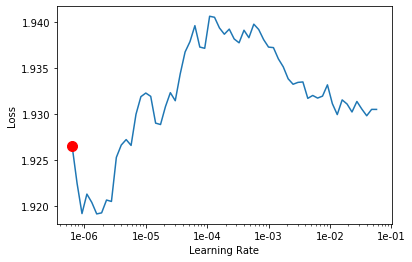

In [90]:
learn.recorder.plot(suggestion = True, skip_end = 10)

In [91]:
callbacks = [EarlyStoppingCallback(learn, patience = 5),
                    SaveModelCallback(learn, every='improvement', monitor='valid_loss')]

In [92]:
lr = 5e-4

In [93]:
learn.fit_one_cycle(20, lr, callbacks = callbacks)

epoch,train_loss,valid_loss,MAELoss,time
0,1.927429,1.904549,1.518056,01:22
1,1.890799,1.854628,1.473595,01:26
2,1.839551,1.809670,1.432937,01:21
3,1.825153,1.803985,1.427726,01:20
4,1.822561,1.798469,1.422547,01:24
5,1.819549,1.793707,1.418434,01:33
6,1.819921,1.796527,1.420378,01:29
7,1.818301,1.798115,1.423188,01:24
8,1.812605,1.794890,1.420052,01:07
9,1.805732,1.799978,1.424320,01:06


Better model found at epoch 0 with valid_loss value: 1.9045488834381104.
Better model found at epoch 1 with valid_loss value: 1.8546278476715088.
Better model found at epoch 2 with valid_loss value: 1.8096697330474854.
Better model found at epoch 3 with valid_loss value: 1.8039848804473877.
Better model found at epoch 4 with valid_loss value: 1.7984693050384521.
Better model found at epoch 5 with valid_loss value: 1.7937074899673462.
Epoch 11: early stopping


In [95]:
#learn.save("current-LSTM30-1")
learn.load("current-LSTM30-1")

Learner(data=DataBunch;

Train: LabelList (99240 items)
x: TimePointsPlusList
A time points plus,A time points plus,A time points plus,A time points plus,A time points plus
y: TargetTimePoints
tensor([[-1.0886, -0.8908, -1.1048, -2.3449, -3.2749, -3.5930, -2.1525, -2.0038,
         -2.8043, -2.3670, -3.1083, -2.7444, -3.4937, -3.1875, -1.0262, -0.3800,
          0.4752,  0.0055, -0.1550, -0.8116, -1.0607, -0.7247,  1.7487,  1.4046,
          1.3173,  2.0793,  0.5842,  1.4477,  2.1981,  2.6715]]),tensor([[-0.8908, -1.1048, -2.3449, -3.2749, -3.5930, -2.1525, -2.0038, -2.8043,
         -2.3670, -3.1083, -2.7444, -3.4937, -3.1875, -1.0262, -0.3800,  0.4752,
          0.0055, -0.1550, -0.8116, -1.0607, -0.7247,  1.7487,  1.4046,  1.3173,
          2.0793,  0.5842,  1.4477,  2.1981,  2.6715,  3.3124]]),tensor([[-1.1048, -2.3449, -3.2749, -3.5930, -2.1525, -2.0038, -2.8043, -2.3670,
         -3.1083, -2.7444, -3.4937, -3.1875, -1.0262, -0.3800,  0.4752,  0.0055,
         -0.1550, -0.8116, -1

In [96]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


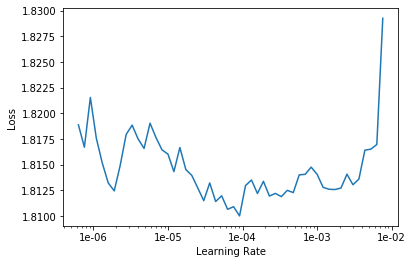

In [97]:
learn.recorder.plot(skip_end = 20)

In [98]:
lr = 3e-5

In [99]:
learn.fit_one_cycle(20, lr, callbacks = callbacks)

epoch,train_loss,valid_loss,MAELoss,time
0,1.819584,1.792814,1.417516,01:06
1,1.817127,1.792142,1.416757,01:06
2,1.814930,1.791521,1.416181,01:05
3,1.815874,1.791648,1.416342,01:06
4,1.814324,1.791435,1.416179,01:04
5,1.812620,1.791971,1.416456,01:05
6,1.820953,1.791144,1.415715,01:05
7,1.818683,1.790897,1.415609,01:07
8,1.818425,1.791288,1.415845,01:09
9,1.809388,1.791096,1.415907,01:08


Better model found at epoch 0 with valid_loss value: 1.7928136587142944.
Better model found at epoch 1 with valid_loss value: 1.7921419143676758.
Better model found at epoch 2 with valid_loss value: 1.7915211915969849.
Better model found at epoch 4 with valid_loss value: 1.7914352416992188.
Better model found at epoch 6 with valid_loss value: 1.791143774986267.
Better model found at epoch 7 with valid_loss value: 1.7908973693847656.
Epoch 13: early stopping


In [40]:
#learn.save("current-LSTM30-2")
learn.load("current-LSTM30-2")

Learner(data=DataBunch;

Train: LabelList (99240 items)
x: TimePointsPlusList
A time points plus,A time points plus,A time points plus,A time points plus,A time points plus
y: TargetTimePoints
tensor([[-1.0886, -0.8908, -1.1048, -2.3449, -3.2749, -3.5930, -2.1525, -2.0038,
         -2.8043, -2.3670, -3.1083, -2.7444, -3.4937, -3.1875, -1.0262, -0.3800,
          0.4752,  0.0055, -0.1550, -0.8116, -1.0607, -0.7247,  1.7487,  1.4046,
          1.3173,  2.0793,  0.5842,  1.4477,  2.1981,  2.6715]]),tensor([[-0.8908, -1.1048, -2.3449, -3.2749, -3.5930, -2.1525, -2.0038, -2.8043,
         -2.3670, -3.1083, -2.7444, -3.4937, -3.1875, -1.0262, -0.3800,  0.4752,
          0.0055, -0.1550, -0.8116, -1.0607, -0.7247,  1.7487,  1.4046,  1.3173,
          2.0793,  0.5842,  1.4477,  2.1981,  2.6715,  3.3124]]),tensor([[-1.1048, -2.3449, -3.2749, -3.5930, -2.1525, -2.0038, -2.8043, -2.3670,
         -3.1083, -2.7444, -3.4937, -3.1875, -1.0262, -0.3800,  0.4752,  0.0055,
         -0.1550, -0.8116, -1

In [41]:
learn.loss_func = nn.MSELoss()#This is just to make it run.
multi_interp = Interpretation.from_learner(learn)

In [42]:
#MAE at each timestep from 1 to 10.
multi_mae_scores = []
for i in range(num_preds):
    multi_mae_scores.append(np.array(np.abs(multi_interp.y_true[:, 0, i] - multi_interp.preds[:, 0, i])))

In [43]:
multi_mae_scores = np.array(multi_mae_scores)

In [44]:
multi_mae_scores.shape

(30, 99870)

In [45]:
for i in range(num_preds):
    print(str(i) + ":", multi_mae_scores[i].mean())

0: 0.89556813
1: 1.0741292
2: 1.1418065
3: 1.2008479
4: 1.2593869
5: 1.3012947
6: 1.3324847
7: 1.3659767
8: 1.4021603
9: 1.4356116
10: 1.4587888
11: 1.4727749
12: 1.4798108
13: 1.4836028
14: 1.487958
15: 1.4942201
16: 1.501639
17: 1.5072833
18: 1.5110035
19: 1.5126165
20: 1.512999
21: 1.5129027
22: 1.5135758
23: 1.5143191
24: 1.515356
25: 1.5157492
26: 1.515898
27: 1.5162394
28: 1.5162523
29: 1.5159917


In [46]:
multi_rmse_scores = []
for i in range(num_preds):
    multi_rmse_scores.append(RMSELoss(multi_interp.preds[:, 0, i], multi_interp.y_true[:, 0, i]))

In [47]:
print(multi_rmse_scores)

[tensor(1.1449), tensor(1.3648), tensor(1.4482), tensor(1.5208), tensor(1.5945), tensor(1.6471), tensor(1.6869), tensor(1.7297), tensor(1.7768), tensor(1.8176), tensor(1.8454), tensor(1.8608), tensor(1.8690), tensor(1.8742), tensor(1.8802), tensor(1.8881), tensor(1.8970), tensor(1.9042), tensor(1.9087), tensor(1.9108), tensor(1.9109), tensor(1.9113), tensor(1.9120), tensor(1.9131), tensor(1.9138), tensor(1.9143), tensor(1.9146), tensor(1.9146), tensor(1.9146), tensor(1.9146)]


In [48]:
total = 0
for i in range(len(multi_interp.y_true)):
    total += RMSELoss(multi_interp.preds[i, 0, :],  multi_interp.y_true[i, 0, :])
    
multi_avg_rmse = total / len(multi_interp.y_true)

In [49]:
multi_avg_rmse

tensor(1.7523)

In [50]:
act_scores = []

In [51]:
for i in range(num_preds):
    act_scores.append(multi_mae_scores[i])
    act_scores.append(uni_mae_scores[i])

Box plot of LFP prediction losses at different time steps in the future
Green = multi-variate, Black = uni-variate

[]

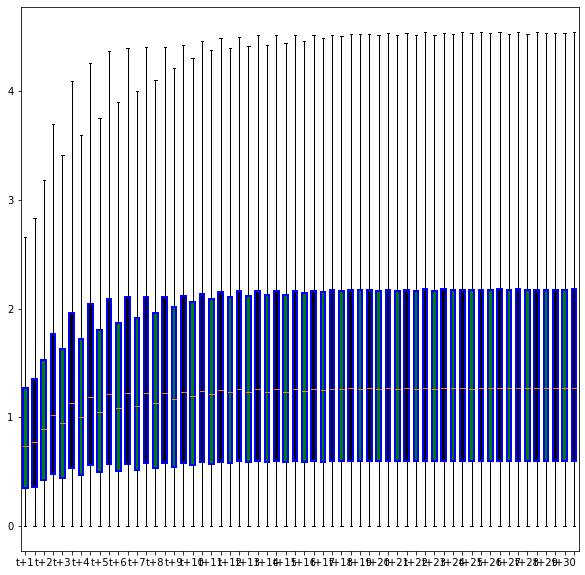

In [52]:
fig = plt.figure(1, figsize=(10, 10))
ax = fig.add_subplot(111)
bp = ax.boxplot(act_scores, showfliers = False, patch_artist = True)
ticks = []
for i in range(num_preds):
    ticks.append("t+" + str(i + 1))
    ticks.append("")
ax.set_xticklabels(ticks)
counter = 0

for box in bp['boxes']:
    # change outline color
    box.set( color='Blue', linewidth=2)
    # change fill color
    if counter % 2 == 0:
        box.set( facecolor = 'Green' )
    else:
        box.set( facecolor = 'Black' )
    counter += 1
    
plt.plot()

In [53]:
for i in range(num_preds):
    print("T-Test p value at t+" + str(i + 1) + ":", scipy.stats.ttest_rel(act_scores[i*2], act_scores[i*2 + 1])[1])
    print("ANOVA p value at t+" + str(i + 1) + ": ", scipy.stats.f_oneway(act_scores[i*2], act_scores[i*2 + 1])[1])
    print()

T-Test p value at t+1: 4.400247253609714e-264
ANOVA p value at t+1:  2.1096317935855601e-75

T-Test p value at t+2: 0.0
ANOVA p value at t+2:  0.0

T-Test p value at t+3: 0.0
ANOVA p value at t+3:  0.0

T-Test p value at t+4: 0.0
ANOVA p value at t+4:  0.0

T-Test p value at t+5: 0.0
ANOVA p value at t+5:  0.0

T-Test p value at t+6: 0.0
ANOVA p value at t+6:  6.114415209868862e-258

T-Test p value at t+7: 0.0
ANOVA p value at t+7:  9.52711146333183e-173

T-Test p value at t+8: 0.0
ANOVA p value at t+8:  2.0075634288189644e-102

T-Test p value at t+9: 0.0
ANOVA p value at t+9:  9.521607600620784e-55

T-Test p value at t+10: 0.0
ANOVA p value at t+10:  4.1544166581007393e-29

T-Test p value at t+11: 1.5915991663258073e-271
ANOVA p value at t+11:  3.08761142923852e-17

T-Test p value at t+12: 2.8237056707146295e-196
ANOVA p value at t+12:  5.838350132153488e-12

T-Test p value at t+13: 2.5211107904565825e-157
ANOVA p value at t+13:  2.1018858538946827e-09

T-Test p value at t+14: 2.59303

examples of forecasts

In [54]:
np.random.seed(seed = 42)

In [55]:
to_show = [np.random.randint(0, 100000) for i in range(15)]

In [59]:
def show_prediction(multi_interp, uni_interp, num_back, index):
    x = np.array(multi_interp.data.valid_ds[index][0].data[0, -num_back:])
    y_true = np.array(multi_interp.y_true[index, 0])
    actual = np.concatenate((x, y_true))
    multi_preds = multi_interp.preds[index, 0]
    uni_preds = uni_interp.preds[index, 0]
    
    x_xs = np.arange(-num_back, num_preds)
    y_xs = np.arange(0, num_preds)

    plt.plot(x_xs, actual, label = "actual")
    plt.plot(y_xs, multi_preds, color='red', label = "multi_pred")
    plt.plot(y_xs, uni_preds, color='green', label = "uni_pred")
    plt.legend()
    plt.show()

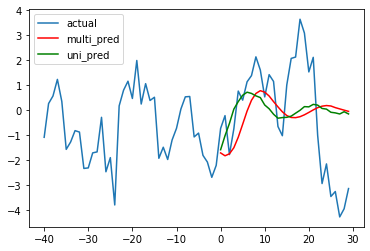

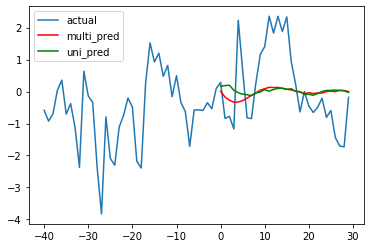

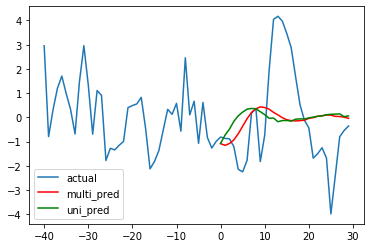

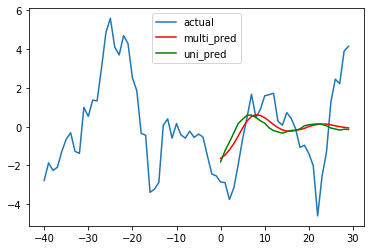

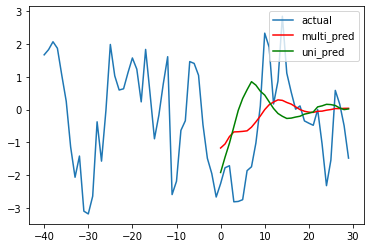

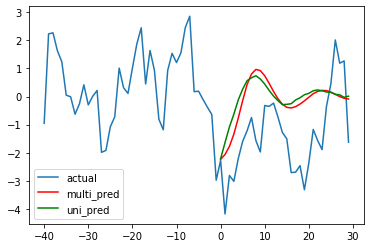

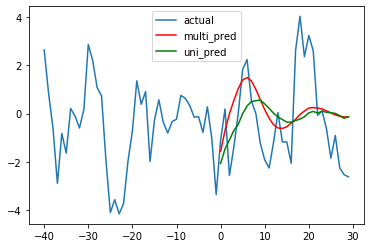

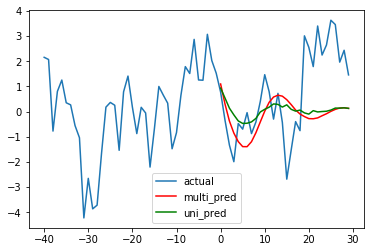

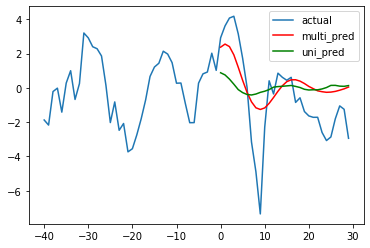

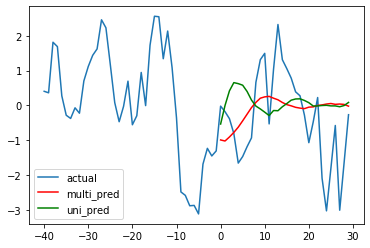

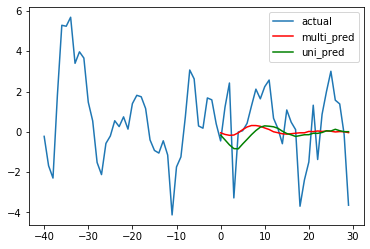

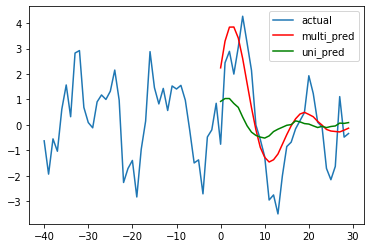

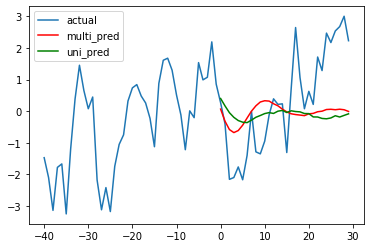

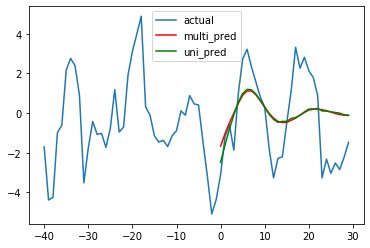

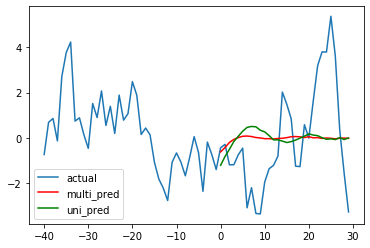

In [60]:
for i in to_show:
    show_prediction(multi_interp, uni_interp, 40, i)

## Large Multivariate

In [162]:
cols = df.columns
cols

Index(['PNA1', 'PNA2', 'PNA3', 'PNA4', 'PNA5', 'PNC1', 'PNC2', 'PNC3', 'PNC4',
       'PNC5', 'ITN1', 'ITN2', 'ITN3', 'ITN4', 'ITN5', 'rawLFP', 'filtLFP',
       'hilbLFP', 'avgPNA', 'avgPNC', 'avgITN'],
      dtype='object')

In [163]:
cols_use = [cols[i] for i in range(16)] + [cols[i] for i in range(18, len(cols))]
cols_use

['PNA1',
 'PNA2',
 'PNA3',
 'PNA4',
 'PNA5',
 'PNC1',
 'PNC2',
 'PNC3',
 'PNC4',
 'PNC5',
 'ITN1',
 'ITN2',
 'ITN3',
 'ITN4',
 'ITN5',
 'rawLFP',
 'avgPNA',
 'avgPNC',
 'avgITN']

In [166]:
y_index = cols_use.index('rawLFP')

In [164]:
num_vars = len(cols_use)
num_vars

19

In [200]:
combine = np.stack(tuple([df[cols_use[i]] for i in range(num_vars)]), axis = -1)

In [181]:
combine.shape

(199500, 19)

In [183]:
num_back = 100
num_preds = 10

In [184]:
data = (TimePointsPlusList(combine, num_back, num_preds, num_vars, y_index)
                .split_by_idx(range(100000))
                .label_from_func(lambda x: x)
                .databunch(bs = 128, num_workers = 0))

In [185]:
data

DataBunch;

Train: LabelList (99280 items)
x: TimePointsPlusList
A time points plus,A time points plus,A time points plus,A time points plus,A time points plus
y: TargetTimePoints
tensor([[-1.0886, -0.8908, -1.1048, -2.3449, -3.2749, -3.5930, -2.1525, -2.0038,
         -2.8043, -2.3670]]),tensor([[-0.8908, -1.1048, -2.3449, -3.2749, -3.5930, -2.1525, -2.0038, -2.8043,
         -2.3670, -3.1083]]),tensor([[-1.1048, -2.3449, -3.2749, -3.5930, -2.1525, -2.0038, -2.8043, -2.3670,
         -3.1083, -2.7444]]),tensor([[-2.3449, -3.2749, -3.5930, -2.1525, -2.0038, -2.8043, -2.3670, -3.1083,
         -2.7444, -3.4937]]),tensor([[-3.2749, -3.5930, -2.1525, -2.0038, -2.8043, -2.3670, -3.1083, -2.7444,
         -3.4937, -3.1875]])
Path: .;

Valid: LabelList (99890 items)
x: TimePointsPlusList
A time points plus,A time points plus,A time points plus,A time points plus,A time points plus
y: TargetTimePoints
tensor([[-1.6335,  1.0956, -0.0752, -0.4381,  1.1608,  0.6629, -0.0546, -0.3383,
          1

In [205]:
data.valid_ds[0][0].data[0]

tensor([ 0.0000,  0.0000,  0.2739,  0.7945,  0.4542,  0.0000,  0.0000,  0.0000,
         0.7978,  0.5977, 60.0000, 16.1290, 18.1650, 19.2410, 22.9290, -0.8585,
         0.3045,  0.2791, 27.2928,  0.0000,  1.4524,  0.5478,  0.7945,  0.6813,
         0.0000,  0.0000,  0.0000,  0.3989,  0.5977,  0.0000, 18.4330, 15.4410,
        16.1210, 14.0530, -1.1468,  0.6952,  0.1993, 12.8096,  0.0000,  0.7262,
         0.2739,  0.0000,  0.6813,  0.0000,  0.0000,  0.7102,  1.1966,  0.0000,
         0.0000, 20.7370, 21.7980, 17.6810, 13.3140,  0.4832,  0.3363,  0.3814,
        14.7060,  0.0000,  0.7262,  0.2739,  0.7945,  0.2271,  0.0000,  1.8416,
         0.7102,  0.3989,  0.5977,  0.0000, 13.8250, 13.6240, 24.4410, 13.3140,
         1.8751,  0.4044,  0.7097, 13.0408,  0.0000,  1.4524,  0.5478,  0.1589,
         1.3627,  0.0000,  0.0000,  2.1307,  0.7978,  1.1955,  0.0000, 16.1290,
        23.6150, 14.0410, 16.2720,  0.0937,  0.7044,  0.8248, 14.0114,  0.0000,
         0.0000,  0.2739,  0.4767,  1.13

In [193]:
data.valid_ds[0][1]

tensor([[-1.6335,  1.0956, -0.0752, -0.4381,  1.1608,  0.6629, -0.0546, -0.3383,
          1.4053,  1.9774]])

In [203]:
combine[:100, 0]

array([0., 0., 0., 0., ..., 0., 0., 0., 0.])

In [171]:
class MultivariateModel(nn.Module):
    def __init__(self, in_size, out_size, num_vars):
        super().__init__()
        self.num_vars = num_vars
        self.rnns = nn.ModuleList([nn.LSTM(in_size, in_size, 4, batch_first = True) for i in range(num_vars)])
        self.lins = nn.ModuleList([nn.Linear(in_size, in_size) for i in range(num_vars)])
        
        self.lin_comb = nn.Linear(in_size * num_vars, in_size)
        
        self.lin1 = nn.Linear(in_size, max(in_size // 2, out_size))
        self.relu = nn.ReLU()
        
        self.lin2 = nn.Linear(max(in_size // 2, out_size), out_size)
        
    def forward(self, x):
        bs, _, seq_len = x.shape
        
        #print(next(iter(self.lins[0].parameters())))
        results = []
        for i in range(self.num_vars):
            temp, _ = self.rnns[i](x[:, i, :].view(bs, 1, seq_len))
            temp = self.lins[i](temp)
            results.append(temp)
        
        res = torch.cat(tuple(results), 2)
        res = self.relu(res)
        res = self.lin_comb(res)
        res = self.relu(res)
        res = self.lin1(res)
        res = self.relu(res)
        res = self.lin2(res)
        return res

In [172]:
learn = Learner(data, MultivariateModel(num_back, num_preds, num_vars), loss_func = RMSELoss, metrics = MAELoss, wd = 1e-1)

In [173]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 5.25E-01
Min loss divided by 10: 3.98E-07


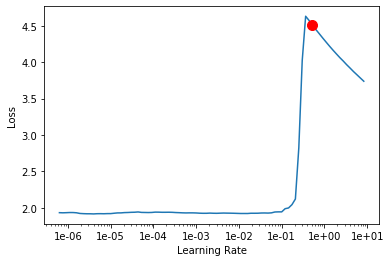

In [176]:
learn.recorder.plot(suggestion = True, skip_end = 0)

In [177]:
callbacks = [EarlyStoppingCallback(learn, patience = 5),
                    SaveModelCallback(learn, every='improvement', monitor='valid_loss')]

In [178]:
lr = 5e-1

In [179]:
learn.fit_one_cycle(20, lr, callbacks = callbacks)

epoch,train_loss,valid_loss,MAELoss,time
0,1.922491,1.904234,1.518663,04:36
1,1.916799,1.904583,1.518450,04:40


Better model found at epoch 0 with valid_loss value: 1.904233694076538.


KeyboardInterrupt: 

## CNN Approach

In [128]:
columns = df.columns

In [129]:
num_forward = 10
num_back = 100
y_index = 15

In [130]:
#Class to store a single input item in the dataset.
#Stores a time series of every variable passed to it, does not contain the label.
#Shape (1, num_back, num_vars)
class TimeWindow(ItemBase):
    def __init__(self, time_window):
        time_window = np.copy(time_window)
        self.obj = (time_window)
        self.data = torch.Tensor(time_window)
        self.data = self.data[None]
        
    def to_one(self): return self.data
    
    def apply_tfms(self, tfms, **kwargs):
        return
    
    def __repr__(self):
        return "A time points plus"
    
#Contains all of the inputs for the data, as well as the capability to label the inputs.
class TimeWindowList(ItemList):
    _label_cls = TargetTimePoints
    def __init__(self, items, num_back, data_input, num_forward, y_index, **kwargs):
        self.its = items
        super().__init__(items, **kwargs)
        self.num_back = num_back
        self.data_input = data_input
        self.y_index = y_index
        self.num_forward = num_forward
        self.copy_new.append("num_forward")
        self.copy_new.append("data_input")
        self.copy_new.append("num_back")
        self.copy_new.append("y_index")
        
    #Returns the input time series starting at index i.
    def get(self, i):
        i = self.items[i]
        return TimeWindow(self.data_input[i - self.num_back : i, :])
    
    def reconstruct(self, t:Tensor):
        return TimeWindow(t)
    
    def __len__(self):
        return len(self.items)
    
    #Called to create a LabelList for the data.
    def label_from_func(self, func:Callable, label_cls:Callable=None, **kwargs)->'LabelList':
        "Apply `func` to every input to get its label."
        return self._label_from_list([self.label_func(o) for o in range(0, len(self))], label_cls=label_cls, **kwargs)
    
    #Determines the label of input i based on the next_above list passed to this class.
    def label_func(self, i):
        return torch.Tensor(self.data_input[self.items[i] : self.items[i] + self.num_forward, self.y_index])

In [131]:
class CNNModel(nn.Module):
    def __init__(self, out_size, num_features):
        super().__init__()
        self.num_features = num_features
        
        #Kernels of size (n, 1) to allow GradCam for individual variables/features.
        self.convs_2d = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size = (9, 1), padding = (4, 0)),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.25),
            nn.Conv2d(64, 128, kernel_size = (7, 1), stride = (2, 1), padding = (3, 0)),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(0.25),
            nn.Conv2d(128, 1, kernel_size = (1,1)),
            nn.ReLU(),
            nn.BatchNorm2d(1),
            nn.Dropout(0.4),
        )
        
        #Combines all features for GradCam over time.
        self.convs_1d = nn.Sequential(
            nn.Conv1d(num_features, 64, kernel_size = (5), padding = (2)),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.4),
            nn.Conv1d(64, 128, kernel_size = (5), stride = 2, padding = (2)),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.4),
        )
        
        #Takes CNN features and turns them into the output.
        self.lins = nn.Sequential(
            #nn.Linear(1280, 640),
            nn.Linear(3200, 640),
            nn.ReLU(),
            nn.BatchNorm1d(640),
            nn.Dropout(),
            nn.Linear(640, 320),
            nn.ReLU(),
            nn.BatchNorm1d(320),
            nn.Dropout(),
            nn.Linear(320, 160),
            nn.ReLU(),
            nn.BatchNorm1d(160),
            nn.Dropout(),
            nn.Linear(160, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(),
            nn.Linear(32, out_size),
        )
        
    def forward(self, x):
        x = self.convs_2d(x)
        x = torch.squeeze(x, dim = 1)
        x = torch.transpose(x, 1, 2)
        x = self.convs_1d(x)
        x = torch.flatten(x, start_dim = 1)
        x = self.lins(x)
        return x

In [132]:
#Stores all input except for filtLFP and hilbLFP.
data_input = np.stack([df[columns[i]] for i in range(16)] + [df[columns[i]] for i in range(-3, 0)], axis = -1)

In [133]:
data_input.shape

(199500, 19)

In [134]:
#Gets the indexes in data_input where it is only 3 or less ms until the next peak 
#and the input does not include a burst.
#Right now only using df[:-30000] so test set is kept, don't know if necessary.
indexes = np.array([i for i in range(200, len(df) - num_forward)])

In [135]:
train_data = (TimeWindowList(indexes, num_back, data_input, num_forward, y_index)
            .split_by_idx(range(100000))
            .label_from_func(lambda x: x)
            .databunch(bs = 64, num_workers = 0))

In [136]:
learn = Learner(train_data, CNNModel(10, 19), loss_func = RMSELoss, metrics = MAELoss, wd = 1e-4)

In [137]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-07
Min loss divided by 10: 4.79E-03


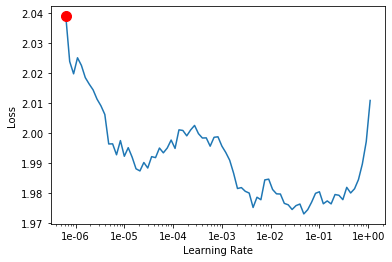

In [138]:
learn.recorder.plot(suggestion = True, skip_end = 10)

In [140]:
callbacks = [EarlyStoppingCallback(learn, patience = 7),
                    SaveModelCallback(learn, every='improvement', monitor='valid_loss')]

In [141]:
lr = 1e-3

In [142]:
learn.fit_one_cycle(20, lr, callbacks = callbacks)

epoch,train_loss,valid_loss,MAELoss,time
0,1.961716,1.894410,1.518897,03:11
1,1.841565,1.765634,1.408200,03:12
2,1.715282,1.609834,1.276892,03:12
3,1.689260,1.596437,1.265758,03:11
4,1.676827,1.580873,1.252398,03:11
5,1.685219,1.582890,1.253388,03:12
6,1.677814,1.574422,1.246136,03:12
7,1.660849,1.577178,1.248700,03:13
8,1.663052,1.569792,1.241549,03:12
9,1.644652,1.571330,1.244123,03:10


Better model found at epoch 0 with valid_loss value: 1.8944098949432373.
Better model found at epoch 1 with valid_loss value: 1.7656337022781372.
Better model found at epoch 2 with valid_loss value: 1.6098335981369019.
Better model found at epoch 3 with valid_loss value: 1.5964372158050537.
Better model found at epoch 4 with valid_loss value: 1.580872654914856.
Better model found at epoch 6 with valid_loss value: 1.574422001838684.
Better model found at epoch 8 with valid_loss value: 1.5697921514511108.
Better model found at epoch 15 with valid_loss value: 1.5661227703094482.


In [143]:
#learn.save("CNN-forecasting")
learn.load("CNN-forecasting")

In [145]:
learn.loss_func = mse

In [146]:
interp = Interpretation.from_learner(learn)

In [ ]:
np.mean()

In [166]:
np.mean(np.array(np.abs(interp.y_true[:, i] - interp.preds[:, i])))

1.0253189

In [168]:
for i in range(10):
    print(np.mean(np.array(np.abs(interp.y_true[:, i] - interp.preds[:, i]))))

1.0253189
1.071955
1.1053617
1.1752357
1.2367461
1.2752044
1.309683
1.3520895
1.4006698
1.4403192


In [ ]:
0.8935518691860652
1.0654175209699996
1.1393258065831269
1.2030068367917348
1.2621465743093432
1.3014963338683856
1.3388055096921843
1.3789303329115985
1.4234806869454668
1.4592803161908046

In [153]:
interp.preds[0]

tensor([ 1.6288,  2.0317,  2.1670,  1.9904,  1.6079,  1.1093,  0.5404,  0.0186,
        -0.4050, -0.6912])

In [154]:
interp.y_true[0]

tensor([2.8569, 2.1359, 3.3028, 0.7796, 0.8758, 1.1563, 1.0176, 1.3948, 1.7165,
        1.4641])

In [151]:
interp.losses[0]

tensor([1.5083e+00, 1.0847e-02, 1.2901e+00, 1.4658e+00, 5.3600e-01, 2.2062e-03,
        2.2771e-01, 1.8939e+00, 4.5008e+00, 4.6454e+00])